# Main plotting script MATCH2BRAIN -- USED FOR SI Figures!
## i.e., RandNouns & LengthControl BMs

`For main conditions: BETTER: run create_match2brain_PlotAndStats.py via create_fig1.sh`

## Import packages

In [1]:
save = True

In [2]:
#import packages
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import json

In [3]:
# import from other scripts
import plot_utils
import stats_utils

## Define approach configuration

In [4]:
model_identifier="gpt2-xl"

In [5]:
#whether or not to include control condition random nouns (used for SI)
randomnouns=True
length_control=False

In [6]:
#load configuration
with open('configurations.json', 'r') as f:
    config = json.load(f)
    
list(config.keys())

['TrainIntact-TestPerturbed:contextualized',
 'TrainIntact-TestPerturbed:decontextualized',
 'TrainPerturbed-TestPerturbed:contextualized',
 'TrainPerturbed-TestPerturbed:decontextualized',
 'TrainPerturbed-TestPerturbed:cv-by-passage']

In [7]:
# get setting
approach = "TrainIntact-TestPerturbed:contextualized" #main is "TrainIntact-TestPerturbed:contextualized"

emb_context=config[approach]["emb_context"]
split_coord=config[approach]["split_coord"]
testonperturbed=config[approach]["testonperturbed"]

In [8]:
import os, sys
import re
import pickle
import numpy as np
import pandas as pd


COND2LABEL = {
        "original" : "Original",
        #
        "scrambled1" : "1LocalWordSwap",
        "scrambled3" : "3LocalWordSwaps",
        "scrambled5" : "5LocalWordSwaps",
        "scrambled7" : "7LocalWordSwaps",
        "backward" : "ReverseOrder",
        "lowpmi" : "LowPMI",
        "lowpmi-random" : "LowPMIRand",
        #
        "contentwords" : "KeepContentW",
        "nounsverbsadj" : "KeepNVAdj",
        "nounsverbs" : "KeepNV",
        "nouns" : "KeepN",
        "functionwords" : "KeepFunctionW",
        #
        "sent_passage" : "RandSentFromPassage",
        "sent_topic" : "RandSentFromTopic",
        "sent_random" : "RandSent",
        #
        "random-wl" : "RandWordList",
        #
        "random-nouns" : "RandN",
        "length-control" : "LengthControl",
        "concatenated-control" : "ConcatenatedControl"
    }


def flatten_list(xss):
    return [x for xs in xss for x in xs]


def get_conditions(testonperturbed=False, randomnouns=False, length_control=False):
    
    if testonperturbed:
        to_prepend = "teston:"
    else:
        to_prepend = ""
        
    original = [f'{to_prepend}original']
    
    conditions_control = [f'{to_prepend}random-wl']

    conditions_scrambled = [f'{to_prepend}scrambled1',
                            f'{to_prepend}scrambled3',
                            f'{to_prepend}scrambled5',
                            f'{to_prepend}scrambled7',
                            f'{to_prepend}backward',
                            f'{to_prepend}lowpmi',
                            f'{to_prepend}lowpmi-random']
    
    if testonperturbed:
        conditions_scrambled = [re.sub("scrambled","scr",elm) for elm in conditions_scrambled]

    conditions_perturb_loss = [f'{to_prepend}contentwords',
                               f'{to_prepend}nounsverbsadj',
                               f'{to_prepend}nounsverbs',
                               f'{to_prepend}nouns',
                               f'{to_prepend}functionwords']
    
    if randomnouns:
        conditions_perturb_loss += [f'{to_prepend}random-nouns']
        
    if length_control:
        conditions_control = [f'{to_prepend}length-control'] + conditions_control

    conditions_perturb_meaning = [f'{to_prepend}sentenceshuffle_passage',
                                  f'{to_prepend}sentenceshuffle_topic',
                                  f'{to_prepend}sentenceshuffle_random']


    #create CAT2COND
    conditions = [original, conditions_scrambled, conditions_perturb_loss, conditions_perturb_meaning, conditions_control]
    categories_unique = ["original", "word-order", "information-loss", "semantic-distance", "control"]
    
    CAT2COND = dict(zip(categories_unique, conditions)) #dictionary from manipulation category to condition
    
    #create COND2CAT
    categories = [["original"] * len(original),
                  ["word-order"] * len(conditions_scrambled),
                  ["information-loss"] * len(conditions_perturb_loss),
                  ["semantic-distance"] * len(conditions_perturb_meaning),
                  ["control"] * len(conditions_control)]
    
    conditions = flatten_list(conditions)
    categories = flatten_list(categories)

    COND2CAT = dict(zip(conditions, categories))

    return CAT2COND, COND2CAT


def get_max_score(matrix):
    """
    input: result = out['data'].values matrix (e.g. for distilgpt2 a matrix of dimensions 7x2)
    output: maximum score and associated error for this matrix.
    """
    max_score, error, best_i = 0,0,0
    for i in range(len(matrix)):
        if matrix[i][0] > max_score:
            max_score = matrix[i][0]
            error = matrix[i][1]
            best_i = i
    return max_score, error, best_i

def get_score_based_on_ind(matrix, index):
    """
    input: result = out['data'].values matrix (e.g. for distilgpt2 a matrix of dimensions 7x2)
    output: maximum score and associated error for this matrix.
    """
    max_score = matrix[index][0]
    error = matrix[index][1]
    return max_score, error



def get_original_scores_df(model_identifier, emb_context="Passage", split_coord="Sentence", testonperturbed=False, randomnouns=False, length_control=False):
    """
    input: model_identifier, embedding context, split_coordinate & whether to test on perturbed sentence
    output: dataframe containing the maximum score and associated error per condition.
    """
    
    working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.score"
    
    CAT2COND, COND2CAT = get_conditions(testonperturbed=testonperturbed, randomnouns=randomnouns, length_control= length_control)
    
    conditions, categories = [], []
    max_scores, errors = [], []
    
    for filename in os.listdir(working_dir):
        
        if os.path.isdir(os.path.join(working_dir,filename)):
            continue
            
        if not testonperturbed:
            if "teston:" in filename:
                continue
        else:
            if not "teston:" in filename:
                continue
                
        if not f"emb_context={emb_context},split_coord={split_coord}" in filename:
            continue
        
        if not "original" in filename:
            continue        

        model_name = filename.split(",")[1]
        bm = filename.split(",")[0]
        
        if bm == "benchmark=Pereira2018-encoding": #exclude old orignial bm in different format
            continue
        
        if "model=" + model_identifier == model_name:
            
            condition = bm.split("benchmark=Pereira2018-encoding-")[-1]
                
#             print(filename, sys.stdout.flush())
            
            #clean name
            condition = re.sub("perturb-","",condition)
            if not any(x in condition for x in ["1", "3", "5", "7"]):
                condition = re.sub("scrambled-","",condition)
            
            if testonperturbed:
                condition = re.sub("scrambled","scr",condition)
                
#             print(condition)

            #load scores
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
                result = out['data'].values
                max_score, error, best_i = get_max_score(result)

            conditions.append(condition)
            categories.append(COND2CAT[condition])
            max_scores.append(max_score)
            errors.append(error)
                
    import pandas as pd
    
    index = conditions
    condition_order = list(COND2CAT.keys())
    
    df = pd.DataFrame({
        'score': max_scores,
        'error': errors,
        'condition': conditions,
        'category': categories})
    
    return df, best_i

def get_remaining_scores_df(best_i, model_identifier, emb_context="Passage", split_coord="Sentence", testonperturbed=False, randomnouns=False, length_control=False):
    """
    input: model_identifier, embedding context, split_coordinate & whether to test on perturbed sentence
    output: dataframe containing the maximum score and associated error per condition.
    """
    
    working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.score"
    
    CAT2COND, COND2CAT = get_conditions(testonperturbed=testonperturbed, randomnouns=randomnouns, length_control= length_control)
    
    conditions, categories = [], []
    max_scores, errors = [], []
    
    for filename in os.listdir(working_dir):
        
        if os.path.isdir(os.path.join(working_dir,filename)):
            continue
            
        if not testonperturbed:
            if "teston:" in filename:
                continue
        else:
            if not "teston:" in filename:
                continue
                
        if not f"emb_context={emb_context}" in filename:
            continue
                
        if not f"split_coord={split_coord}" in filename:
            continue
        
        exclude_list = ["-control", "random-nouns", "original"]
        
        if randomnouns:
            exclude_list = ["-control", "original"]
        if length_control:
            include_list = ["original", "length-control", "random-wl"]
            
        if length_control:
            if all(x not in filename for x in include_list):
                continue
        else:
            if any(x in filename for x in exclude_list):
                continue
                        

        model_name = filename.split(",")[1]
        bm = filename.split(",")[0]
        
        if bm == "benchmark=Pereira2018-encoding": #exclude old orignial bm in different format
            continue
        
        if "model=" + model_identifier == model_name:
            
            condition = bm.split("benchmark=Pereira2018-encoding-")[-1]
                
#             print(filename, sys.stdout.flush())
            
            #clean name
            condition = re.sub("perturb-","",condition)
            if not any(x in condition for x in ["1", "3", "5", "7"]):
                condition = re.sub("scrambled-","",condition)
            
            if testonperturbed:
                condition = re.sub("scrambled","scr",condition)
                
#             print(condition)

            #load scores
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
                result = out['data'].values
                max_score, error = get_score_based_on_ind(result, best_i)
                print(f"Getting result for layer {best_i}")

            conditions.append(condition)
            categories.append(COND2CAT[condition])
            max_scores.append(max_score)
            errors.append(error)

                
    import pandas as pd
    
    index = conditions
    condition_order = list(COND2CAT.keys())
    
    df = pd.DataFrame({
        'score': max_scores,
        'error': errors,
        'condition': conditions,
        'category': categories})
    
    return df

def get_best_scores_df(model_identifier, emb_context="Passage", split_coord="Sentence", testonperturbed=False, randomnouns=False, length_control=False):
    original_df, best_i = get_original_scores_df(model_identifier=model_identifier,
                                                 emb_context=emb_context,
                                                 split_coord=split_coord,
                                                 testonperturbed=testonperturbed,
                                                 randomnouns=randomnouns,
                                                 length_control=length_control)
    remaining_scores_df = get_remaining_scores_df(best_i, model_identifier=model_identifier,
                                                 emb_context=emb_context,
                                                 split_coord=split_coord,
                                                 testonperturbed=testonperturbed,
                                                 randomnouns=randomnouns,
                                                 length_control=length_control)
    
    df = pd.concat([original_df, remaining_scores_df])
    CAT2COND, COND2CAT = get_conditions(testonperturbed=testonperturbed, randomnouns=randomnouns, length_control= length_control)
    condition_order = list(COND2CAT.keys())
    df['condition'] = pd.Categorical(df['condition'], categories=condition_order, ordered=True)
    scores_df = df.sort_values(by='condition').reset_index(drop=True)
    
    #clean names
    scores_df['condition'] = scores_df['condition'].str.replace("teston:","")
    scores_df['condition'] = scores_df['condition'].replace(
    {'sentenceshuffle_random': 'sent_random',
    'sentenceshuffle_passage': 'sent_passage',
    'sentenceshuffle_topic': 'sent_topic',
    'scr1': 'scrambled1',
    'scr3': 'scrambled3',
    'scr5': 'scrambled5',
    'scr7': 'scrambled7'}
    )
    
    return scores_df

def get_sample_stimuli(getall=False, randomnouns=False, length_control=False):
    working_dir = "/om2/user/ckauf/perturbed-neural-nlp/ressources/scrambled_stimuli_dfs/"
    
    # Translate between names for stimuli dataframes and condition names used for plotting
    conditions = [
    ('Original', 'original'),
        #
    ('Scr1', 'scrambled1'),
    ('Scr3', 'scrambled3'),
    ('Scr5', 'scrambled5'),
    ('Scr7', 'scrambled7'),
    ('backward', 'backward'),
    ('lowPMI', 'lowpmi'),
    ('lowPMI_random', 'lowpmi-random'),
        #
    ('contentwords', 'contentwords'),
    ('nounsverbsadj', 'nounsverbsadj'),
    ('nounsverbs', 'nounsverbs'),
    ('nouns', 'nouns'),
    ('functionwords', 'functionwords'),
        #
    ('sentenceshuffle-withinpassage', 'sent_passage'),
    ('sentenceshuffle-withintopic', 'sent_topic'),
    ('sentenceshuffle-random', 'sent_random'),
        #
    ('random', 'random-wl')
    ]
    
    if randomnouns:
        conditions.append(('randomnouns', 'random-nouns'))
    if length_control:
        conditions.append(('length_control', 'length-control'))
    
    # set up empty lists
    conds, sentences = [], []
    
    # populate lists
    for (stimuli_name, condition) in conditions:
        print(f"{stimuli_name} | {condition}")
        for filename in os.listdir(working_dir):
            if filename == f'stimuli_{stimuli_name}.pkl':
                with open(os.path.join(working_dir,filename), 'rb') as f:
                    df = pickle.load(f)
                    
                if getall:
                    sentences += list(df["sentence"])
                    conds += [condition] * len(list(df["sentence"]))
                else:
                    sentences += list(df["sentence"])[:1]
                    conds += [condition]
                
    sample_stim_df = pd.DataFrame({
    'condition' : conds,
    'stimulus': sentences
    })     
    
    return sample_stim_df

## Get stimuli

In [9]:
stimuli_df = plot_utils.get_sample_stimuli(randomnouns=randomnouns,length_control=length_control)
stimuli_df

Original | original
Loading lookup from /om2/user/ckauf/anaconda39/envs/perturbed3.8/lib/python3.8/site-packages/brainio_collection/lookup.csv
/net/vast-storage.ib.cluster/scratch/vast/cpl/ckauf/perturbed-neural-nlp/neural_nlp/../ressources/stimuli
I AM USING THE NEW SPLIT FUNCTION
I AM USING THE NEW CROSSVALIDATION SCRIPT
Scr1 | scrambled1
Scr3 | scrambled3
Scr5 | scrambled5
Scr7 | scrambled7
backward | backward
lowPMI | lowpmi
lowPMI_random | lowpmi-random
contentwords | contentwords
nounsverbsadj | nounsverbsadj
nounsverbs | nounsverbs
nouns | nouns
functionwords | functionwords
sentenceshuffle-withinpassage | sent_passage
sentenceshuffle-withintopic | sent_topic
sentenceshuffle-random | sent_random
random | random-wl
randomnouns | random-nouns


,condition,stimulus
0,original,beekeeping encourages the conservation of loca...
1,scrambled1,beekeeping encourages the conservation of habi...
2,scrambled3,beekeeping conservation encourages the of habi...
3,scrambled5,conservation beekeeping encourages the habitat...
4,scrambled7,beekeeping conservation of encourages habitats...
5,backward,habitats local of conservation the encourages ...
6,lowpmi,beekeeping conservation habitats the of encour...
7,lowpmi-random,encourages the beekeeping of habitats conserva...
8,contentwords,beekeeping encourages conservation local habit...
9,nounsverbsadj,beekeeping encourages conservation local habit...


In [10]:
# function check (this is done in the main function below!)
scores_df = get_best_scores_df(model_identifier=model_identifier,
                                          emb_context=emb_context,
                                          split_coord=split_coord,
                                          testonperturbed=testonperturbed,
                                          randomnouns=randomnouns,length_control=length_control)
scores_df

Getting result for layer 45
Getting result for layer 45
Getting result for layer 45
Getting result for layer 45
Getting result for layer 45
Getting result for layer 45
Getting result for layer 45
Getting result for layer 45
Getting result for layer 45
Getting result for layer 45
Getting result for layer 45
Getting result for layer 45
Getting result for layer 45
Getting result for layer 45
Getting result for layer 45
Getting result for layer 45
Getting result for layer 45


,score,error,condition,category
0,1.107199,0.141840,original,original
1,1.019374,0.120393,scrambled1,word-order
2,0.858562,0.131549,scrambled3,word-order
3,0.834716,0.142040,scrambled5,word-order
4,0.798727,0.128002,scrambled7,word-order
5,0.602144,0.177734,backward,word-order
6,0.820582,0.092441,lowpmi,word-order
7,0.746207,0.102075,lowpmi-random,word-order
8,0.875717,0.084836,contentwords,information-loss
9,0.856148,0.055101,nounsverbsadj,information-loss


### merge with stimuli df

In [11]:
full_df = scores_df.merge(stimuli_df, on='condition', how='inner')
full_df

,score,error,condition,category,stimulus
0,1.107199,0.141840,original,original,beekeeping encourages the conservation of loca...
1,1.019374,0.120393,scrambled1,word-order,beekeeping encourages the conservation of habi...
2,0.858562,0.131549,scrambled3,word-order,beekeeping conservation encourages the of habi...
3,0.834716,0.142040,scrambled5,word-order,conservation beekeeping encourages the habitat...
4,0.798727,0.128002,scrambled7,word-order,beekeeping conservation of encourages habitats...
5,0.602144,0.177734,backward,word-order,habitats local of conservation the encourages ...
6,0.820582,0.092441,lowpmi,word-order,beekeeping conservation habitats the of encour...
7,0.746207,0.102075,lowpmi-random,word-order,encourages the beekeeping of habitats conserva...
8,0.875717,0.084836,contentwords,information-loss,beekeeping encourages conservation local habit...
9,0.856148,0.055101,nounsverbsadj,information-loss,beekeeping encourages conservation local habit...


In [12]:
#Rename conditions according to new names:
full_df['condition'] = full_df['condition'].map(plot_utils.COND2LABEL)

In [13]:
full_df["labelname"] = [': '.join(i) for i in zip(full_df["condition"].map(str),full_df["stimulus"])]
full_df

,score,error,condition,category,stimulus,labelname
0,1.107199,0.141840,Original,original,beekeeping encourages the conservation of loca...,Original: beekeeping encourages the conservati...
1,1.019374,0.120393,1LocalWordSwap,word-order,beekeeping encourages the conservation of habi...,1LocalWordSwap: beekeeping encourages the cons...
2,0.858562,0.131549,3LocalWordSwaps,word-order,beekeeping conservation encourages the of habi...,3LocalWordSwaps: beekeeping conservation encou...
3,0.834716,0.142040,5LocalWordSwaps,word-order,conservation beekeeping encourages the habitat...,5LocalWordSwaps: conservation beekeeping encou...
4,0.798727,0.128002,7LocalWordSwaps,word-order,beekeeping conservation of encourages habitats...,7LocalWordSwaps: beekeeping conservation of en...
5,0.602144,0.177734,ReverseOrder,word-order,habitats local of conservation the encourages ...,ReverseOrder: habitats local of conservation t...
6,0.820582,0.092441,LowPMI,word-order,beekeeping conservation habitats the of encour...,LowPMI: beekeeping conservation habitats the o...
7,0.746207,0.102075,LowPMIRand,word-order,encourages the beekeeping of habitats conserva...,LowPMIRand: encourages the beekeeping of habit...
8,0.875717,0.084836,KeepContentW,information-loss,beekeeping encourages conservation local habit...,KeepContentW: beekeeping encourages conservati...
9,0.856148,0.055101,KeepNVAdj,information-loss,beekeeping encourages conservation local habit...,KeepNVAdj: beekeeping encourages conservation ...


## Get stats

In [14]:
import scipy
import statsmodels

#Benjamini/Hochberg corrected
def get_ttest_results(model_identifier, emb_context="Passage", split_coord="Sentence",
                testonperturbed=False, category=None, randomnouns=False, length_control=False):
    
    subdf = stats_utils.get_stats_df(model_identifier=model_identifier, emb_context=emb_context,
                                     split_coord=split_coord, testonperturbed=testonperturbed,
                                    randomnouns = randomnouns, length_control=length_control)

    pvals2original, pvals2random = [], []
    ttest2original, ttest2random = [], []
    cohensd2original, cohensd2random = [], []
    conds = []
    
    CAT2COND, COND2CAT = plot_utils.get_conditions(testonperturbed=False,
                                                   randomnouns = randomnouns,
                                                   length_control=length_control)
    for cond in CAT2COND[category]:
        if length_control and "random-wl" in cond:
            continue
        
        #adjust names for consistency
        if cond == 'sentenceshuffle_random':
            cond = 'sent_random'
        elif cond == 'sentenceshuffle_passage':
            cond = 'sent_passage'
        elif cond == 'sentenceshuffle_topic':
            cond = 'sent_topic'

        #get subject scores
        original_scores = list(subdf[subdf['condition'] == 'original']["values"])
        cond_scores = list(subdf[subdf['condition'] == cond]["values"])
        random_scores = list(subdf[subdf['condition'] == 'random-wl']["values"])
        
        #get ttest
        ttest2orig, pval2orig = scipy.stats.ttest_ind(original_scores,cond_scores)
        ttest2rand, pval2rand = scipy.stats.ttest_ind(random_scores,cond_scores)
        
        # get effect size
        cohensd2orig = stats_utils.cohens_d(original_scores, cond_scores)
        cohensd2rand = stats_utils.cohens_d(random_scores, cond_scores)
        
        conds.append(cond)
        pvals2original.append(pval2orig)
        ttest2original.append(ttest2orig)
        pvals2random.append(pval2rand)
        ttest2random.append(ttest2rand)
        cohensd2original.append(cohensd2orig)
        cohensd2random.append(cohensd2rand)
        
    # correct for multiple comparisons
    # statsmodels.stats.multitest.fdrcorrection(pvals) = statsmodels.stats.multitest.multipletests(pvals, method='fdr_bh')
    # first output is list of Booleans indicating whether to reject null hypothesis or not
    _, adjusted_pvals2original = statsmodels.stats.multitest.fdrcorrection(pvals2original)
    _, adjusted_pvals2random = statsmodels.stats.multitest.fdrcorrection(pvals2random)
    
    #assign significance levels
    significance2original = stats_utils.assign_significance_labels(adjusted_pvals2original)
    significance2random = stats_utils.assign_significance_labels(adjusted_pvals2random)
    
    
    stats_df = pd.DataFrame({
        "condition": conds,
        "ttest2original" : ttest2original,
        "ttest2random" : ttest2random,
        "adjusted_pvals2original" : adjusted_pvals2original,
        "adjusted_pvals2random" : adjusted_pvals2random,
        "cohensd2original" : cohensd2original,
        "cohensd2random" : cohensd2random,
        "significance2original" : significance2original,
        "significance2random" : significance2random,
        "pvals2original" : pvals2original,
        "pvals2random" : pvals2random
    })
    
    return stats_df

In [15]:
subdf = stats_utils.get_stats_df(model_identifier=model_identifier, emb_context=emb_context,
                                     split_coord=split_coord, testonperturbed=testonperturbed,
                                    randomnouns = randomnouns, length_control=length_control)

random_scores = list(subdf[subdf['condition'] == 'random-wl']["values"])
tstat, pval = scipy.stats.ttest_1samp(random_scores, popmean=0, axis=0, nan_policy='propagate', alternative='two-sided')
print(f"Testing for difference to 0 for random-wl for {model_identifier}")
print(f"One-sample ttest: {tstat}\npvalue: {pval}\n")


random_sent_scores = list(subdf[subdf['condition'] == 'sent_random']["values"])
tstat, pval = scipy.stats.ttest_1samp(random_sent_scores, popmean=0, axis=0, nan_policy='propagate', alternative='two-sided')
print(f"Testing for difference to 0 for sent_random for {model_identifier}")
print(f"One-sample ttest: {tstat}\npvalue: {pval}")

Testing for difference to 0 for random-wl for gpt2-xl
One-sample ttest: 3.1723661545617863
pvalue: 0.011322832097651767

Testing for difference to 0 for sent_random for gpt2-xl
One-sample ttest: 2.6719153879579554
pvalue: 0.02554216696619439


In [16]:
subdf

,condition,values,category
89,original,0.348416,original
82,original,0.308316,original
83,original,0.339043,original
84,original,0.357018,original
85,original,0.395303,original
...,...,...,...
104,random-wl,0.054398,control
105,random-wl,0.044900,control
106,random-wl,0.049018,control
107,random-wl,-0.043090,control


In [17]:
length_control_scores = list(subdf[subdf['condition'] == 'length-control']["values"])
tstat, pval = scipy.stats.ttest_1samp(length_control_scores, popmean=0, axis=0, nan_policy='propagate', alternative='two-sided')
print(f"Testing for difference to 0 for length-control for {model_identifier}")
print(f"One-sample ttest: {tstat}\npvalue: {pval}")

Testing for difference to 0 for length-control for gpt2-xl
One-sample ttest: nan
pvalue: nan


In [18]:
if randomnouns:
    subdf = stats_utils.get_stats_df(model_identifier=model_identifier, emb_context=emb_context,
                                     split_coord=split_coord, testonperturbed=testonperturbed,
                                    randomnouns = randomnouns,length_control=length_control)
    
    randomnouns_scores = list(subdf[subdf['condition'] == 'random-nouns']["values"])
    functionword_scores = list(subdf[subdf['condition'] == 'functionwords']["values"])
    #get ttest
    ttest, pval = scipy.stats.ttest_ind(randomnouns_scores, functionword_scores)
    # get effect size
    cohensd = stats_utils.cohens_d(randomnouns_scores, functionword_scores)
    print(f"RANDOM NOUNS vs. FUNCTIONWORDS \nttest: {ttest} \npval: {pval} \ncohen's d: {cohensd}")

RANDOM NOUNS vs. FUNCTIONWORDS 
ttest: -1.8071632936529487 
pval: 0.08748116431575835 
cohen's d: -0.8081879942100815


In [19]:
frames = []
if not length_control:
    for category in ["word-order", "information-loss", "semantic-distance"]:
        stats_df = get_ttest_results(model_identifier=model_identifier,
                          emb_context=emb_context,
                          split_coord=split_coord,
                          testonperturbed=testonperturbed,
                          category=category, randomnouns=randomnouns)
        frames.append(stats_df)
else:
    stats_df = get_ttest_results(model_identifier=model_identifier,
                      emb_context=emb_context,
                      split_coord=split_coord,
                      testonperturbed=testonperturbed,
                      category="control", randomnouns=randomnouns,
                                length_control=length_control)
    frames.append(stats_df)
full_stats_df = pd.concat(frames)

full_stats_df

,condition,ttest2original,ttest2random,adjusted_pvals2original,adjusted_pvals2random,cohensd2original,cohensd2random,significance2original,significance2random,pvals2original,pvals2random
0,scrambled1,1.278297,-18.532649,2.173829e-01,4.169681e-13,0.571672,-8.288052,n.s.,***,2.173829e-01,3.574013e-13
1,scrambled3,3.415087,-21.212587,3.601046e-03,9.795906e-14,1.527273,-9.486557,**,***,3.086610e-03,3.478449e-14
2,scrambled5,3.644457,-20.845106,3.245156e-03,9.795906e-14,1.629851,-9.322215,**,***,1.854375e-03,4.708901e-14
3,scrambled7,3.668394,-20.637976,3.245156e-03,9.795906e-14,1.640556,-9.229584,**,***,1.758147e-03,5.597661e-14
4,backward,5.329610,-18.023275,3.202245e-04,5.760193e-13,2.383474,-8.060254,***,***,4.574636e-05,5.760193e-13
5,lowpmi,3.487580,-22.346267,3.601046e-03,9.795906e-14,1.559693,-9.993554,**,***,2.628205e-03,1.407780e-14
6,lowpmi-random,4.568393,-19.099773,8.338803e-04,2.981863e-13,2.043047,-8.541678,***,***,2.382515e-04,2.129902e-13
0,contentwords,4.148265,-15.967729,6.037984e-04,2.175477e-11,1.855161,-7.140986,***,***,6.037984e-04,4.508254e-12
1,nounsverbsadj,4.420397,-14.795807,3.962749e-04,3.241893e-11,1.976862,-6.616886,***,***,3.302291e-04,1.620947e-11
2,nounsverbs,6.029842,-15.523387,1.590364e-05,2.175477e-11,2.696627,-6.942270,***,***,1.060242e-05,7.251589e-12


In [20]:
#Rename conditions according to new names:
full_stats_df['condition'] = full_stats_df['condition'].map(plot_utils.COND2LABEL)
full_stats_df

,condition,ttest2original,ttest2random,adjusted_pvals2original,adjusted_pvals2random,cohensd2original,cohensd2random,significance2original,significance2random,pvals2original,pvals2random
0,1LocalWordSwap,1.278297,-18.532649,2.173829e-01,4.169681e-13,0.571672,-8.288052,n.s.,***,2.173829e-01,3.574013e-13
1,3LocalWordSwaps,3.415087,-21.212587,3.601046e-03,9.795906e-14,1.527273,-9.486557,**,***,3.086610e-03,3.478449e-14
2,5LocalWordSwaps,3.644457,-20.845106,3.245156e-03,9.795906e-14,1.629851,-9.322215,**,***,1.854375e-03,4.708901e-14
3,7LocalWordSwaps,3.668394,-20.637976,3.245156e-03,9.795906e-14,1.640556,-9.229584,**,***,1.758147e-03,5.597661e-14
4,ReverseOrder,5.329610,-18.023275,3.202245e-04,5.760193e-13,2.383474,-8.060254,***,***,4.574636e-05,5.760193e-13
5,LowPMI,3.487580,-22.346267,3.601046e-03,9.795906e-14,1.559693,-9.993554,**,***,2.628205e-03,1.407780e-14
6,LowPMIRand,4.568393,-19.099773,8.338803e-04,2.981863e-13,2.043047,-8.541678,***,***,2.382515e-04,2.129902e-13
0,KeepContentW,4.148265,-15.967729,6.037984e-04,2.175477e-11,1.855161,-7.140986,***,***,6.037984e-04,4.508254e-12
1,KeepNVAdj,4.420397,-14.795807,3.962749e-04,3.241893e-11,1.976862,-6.616886,***,***,3.302291e-04,1.620947e-11
2,KeepNV,6.029842,-15.523387,1.590364e-05,2.175477e-11,2.696627,-6.942270,***,***,1.060242e-05,7.251589e-12


In [21]:
if save and length_control:
    full_stats_df.to_csv(f"results_paper/figure1+2/stats_{approach}_length_control.csv",index=False)

In [22]:
test = full_stats_df[['condition', 'ttest2original', 'adjusted_pvals2original', 'cohensd2original']].T
test, test.columns = test[1:] , test.iloc[0]
test

condition,1LocalWordSwap,3LocalWordSwaps,5LocalWordSwaps,7LocalWordSwaps,ReverseOrder,LowPMI,LowPMIRand,KeepContentW,KeepNVAdj,KeepNV,KeepN,KeepFunctionW,RandN,RandSentFromPassage,RandSentFromTopic,RandSent
ttest2original,1.2783,3.41509,3.64446,3.66839,5.32961,3.48758,4.56839,4.14827,4.4204,6.02984,10.8277,22.0615,22.4759,4.76739,15.7896,24.15
adjusted_pvals2original,0.217383,0.00360105,0.00324516,0.00324516,0.000320225,0.00360105,0.00083388,0.000603798,0.000396275,1.59036e-05,5.18304e-09,5.27895e-14,5.27895e-14,0.000153983,8.17003e-12,1.09009e-14
cohensd2original,0.571672,1.52727,1.62985,1.64056,2.38347,1.55969,2.04305,1.85516,1.97686,2.69663,4.84229,9.86622,10.0515,2.13204,7.06134,10.8002


In [23]:
stats2original = full_stats_df[['condition', 'ttest2original', 'adjusted_pvals2original', 'cohensd2original']]

In [24]:
full_stats_df[['condition', 'ttest2random', 'adjusted_pvals2random', 'cohensd2random']]

,condition,ttest2random,adjusted_pvals2random,cohensd2random
0,1LocalWordSwap,-18.532649,4.169681e-13,-8.288052
1,3LocalWordSwaps,-21.212587,9.795906e-14,-9.486557
2,5LocalWordSwaps,-20.845106,9.795906e-14,-9.322215
3,7LocalWordSwaps,-20.637976,9.795906e-14,-9.229584
4,ReverseOrder,-18.023275,5.760193e-13,-8.060254
5,LowPMI,-22.346267,9.795906e-14,-9.993554
6,LowPMIRand,-19.099773,2.981863e-13,-8.541678
0,KeepContentW,-15.967729,2.175477e-11,-7.140986
1,KeepNVAdj,-14.795807,3.241893e-11,-6.616886
2,KeepNV,-15.523387,2.175477e-11,-6.942270


## Plot

In [25]:
#define global figure settings
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "" #gets rid of horizontal lines
                }
sns.set_theme(font_scale=1.4, style="white", rc=custom_params)

In [26]:
#define colors
CAT2COLOR = {
    "original": "dimgray",
    #
    "word-order": sns.cubehelix_palette(7, start=.2, rot=-.25, dark=0.2, light=.9, reverse=True),
    "information-loss": sns.cubehelix_palette(5, start=2, rot=0, dark=0.2, light=.85, reverse=True),
    #cut off as last gradient color is similar across colors
    "semantic-distance": sns.light_palette("maroon", 4, reverse=True)[:3],
    #
    "control": "lightgray"
}

if randomnouns:
    CAT2COLOR["information-loss"] = sns.cubehelix_palette(6, start=2, rot=0, dark=0.2, light=.85, reverse=True)

In [27]:
full_df

,score,error,condition,category,stimulus,labelname
0,1.107199,0.141840,Original,original,beekeeping encourages the conservation of loca...,Original: beekeeping encourages the conservati...
1,1.019374,0.120393,1LocalWordSwap,word-order,beekeeping encourages the conservation of habi...,1LocalWordSwap: beekeeping encourages the cons...
2,0.858562,0.131549,3LocalWordSwaps,word-order,beekeeping conservation encourages the of habi...,3LocalWordSwaps: beekeeping conservation encou...
3,0.834716,0.142040,5LocalWordSwaps,word-order,conservation beekeeping encourages the habitat...,5LocalWordSwaps: conservation beekeeping encou...
4,0.798727,0.128002,7LocalWordSwaps,word-order,beekeeping conservation of encourages habitats...,7LocalWordSwaps: beekeeping conservation of en...
5,0.602144,0.177734,ReverseOrder,word-order,habitats local of conservation the encourages ...,ReverseOrder: habitats local of conservation t...
6,0.820582,0.092441,LowPMI,word-order,beekeeping conservation habitats the of encour...,LowPMI: beekeeping conservation habitats the o...
7,0.746207,0.102075,LowPMIRand,word-order,encourages the beekeeping of habitats conserva...,LowPMIRand: encourages the beekeeping of habit...
8,0.875717,0.084836,KeepContentW,information-loss,beekeeping encourages conservation local habit...,KeepContentW: beekeeping encourages conservati...
9,0.856148,0.055101,KeepNVAdj,information-loss,beekeeping encourages conservation local habit...,KeepNVAdj: beekeeping encourages conservation ...


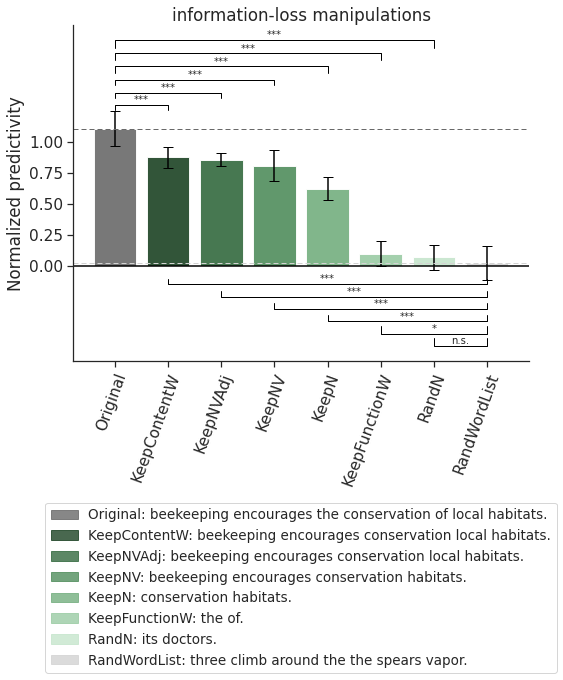

In [28]:
import math

categories = ["word-order", "information-loss", "semantic-distance"]
if randomnouns:
    categories = ["information-loss"]
if length_control:
    categories = ["control"]
    
num_bars = [len(full_df[full_df["category"] == cat]) for cat in categories]
max_bars = max(num_bars)
nrows = len(categories)

fig2 = plt.figure(constrained_layout=True, figsize=(8*nrows, 11), facecolor='white')
props = [1 + 0.2*x for x in num_bars]
spec2 = GridSpec(ncols=nrows, nrows=1, figure=fig2)
f2_ax = []

to_add = 0
    
for ind, current_category in enumerate(categories):
    #set up subplot
    if ind == 0:
        f2_ax.append(fig2.add_subplot(spec2[0, ind]))
    else:
        f2_ax.append(fig2.add_subplot(spec2[0, ind], sharey=f2_ax[0]))

    categories = ["original", current_category, "control"]
    plot_df = full_df[full_df["category"].isin(categories)]
    
    if length_control:
        colors = [CAT2COLOR["original"]] + [CAT2COLOR[current_category]] + [CAT2COLOR["control"]]
    else:
        colors = [CAT2COLOR["original"]] + CAT2COLOR[current_category] + [CAT2COLOR["control"]]
    
    x_pos = np.arange(len(plot_df))
    scores = list(plot_df['score'])
    errors = list(plot_df['error'])
    conditions = list(plot_df['condition'])
                
    stimuli = [list(plot_df.loc[plot_df["category"] == cat]["labelname"]) for cat in categories]
    stimuli = plot_utils.flatten_list(stimuli)
    from textwrap import fill
    stimuli = [fill(l, 75) for l in stimuli]
    
    #add empty slots for same bar width
    if len(x_pos) != max_bars + 2: # +2 because of original and random-wl
        to_add = max_bars - num_bars[ind]
        x_pos = np.arange(len(plot_df) + to_add)
        multiplier1 = math.floor(to_add/2)
        multiplier2 = math.ceil(to_add/2)

        insert_at1 = 1
        insert_at2 = -1

        insert_elements1 = [np.nan]*multiplier1
        insert_elements2 = [np.nan]*multiplier2
        #
        scores[insert_at1:insert_at1] = insert_elements1
        scores[insert_at2:insert_at2] = insert_elements2
        #
        errors[insert_at1:insert_at1] = insert_elements1
        errors[insert_at2:insert_at2] = insert_elements2

        insert_elements1 = [""]*multiplier1
        insert_elements2 = [""]*multiplier2
        #
        conditions[insert_at1:insert_at1] = insert_elements1
        conditions[insert_at2:insert_at2] = insert_elements2
        #
        stimuli[insert_at1:insert_at1] = insert_elements1
        stimuli[insert_at2:insert_at2] = insert_elements2

        insert_elements1 = ["white"]*multiplier1
        insert_elements2 = ["white"]*multiplier2
        
        colors[insert_at1:insert_at1] = insert_elements1
        colors[insert_at2:insert_at2] = insert_elements2

    f2_ax[-1].bar(x_pos, scores,
        yerr=errors,
        align='center',
        alpha=0.9, #color intensity
        ecolor='black',
        capsize=5, #error-bar width
        color=colors)
    
    CAT2COND, COND2CAT = plot_utils.get_conditions(randomnouns=randomnouns, length_control=length_control)
    
    #annotate stats 2 original
    for ind_c, cond in enumerate(CAT2COND[current_category]):
        #adjust names for consistency
        if cond == 'sentenceshuffle_random':
            cond = 'sent_random'
        elif cond == 'sentenceshuffle_passage':
            cond = 'sent_passage'
        elif cond == 'sentenceshuffle_topic':
            cond = 'sent_topic'
            
        cond = plot_utils.COND2LABEL[cond]
            
        if cond in ["Original", "RandWordList"]:
            continue

        idx_random = conditions.index("RandWordList") - to_add

        positions = [i for i, score in enumerate(scores) if not np.isnan(score)]
        #print(positions)
        
        #add stats annotations for comparison with original score
        heights = [scores[0]] * len(positions)
        #add height offset to annotations
        height_offset = [0.1 * i for i in range(len(heights))]
        heights = [sum(x) for x in zip(heights, height_offset)]
        label = full_stats_df.loc[full_stats_df["condition"] == cond]["significance2original"].item()
        stats_utils.barplot_annotate_brackets(0, ind_c+1, data=label, center=positions, height=heights, fs=10)
        
        #add stats annotations for comparison with random-wl score
        heights = [0] * len(positions)
        #add height offset to annotations
        height_offset = [-0.1 * i for i in range(len(heights))]
        heights = [sum(x) for x in zip(heights, height_offset)]
        label = full_stats_df.loc[full_stats_df["condition"] == cond]["significance2random"].item()
        stats_utils.barplot_annotate_brackets(ind_c+1, idx_random, data=label, center=positions, height=heights,
                                             updown="down", fs=10)
    
    #add horizontal lines for original and random-wl
    orig_score = full_df[full_df["condition"]=="Original"]["score"].item()
    random_score = full_df[full_df["condition"]=="RandWordList"]["score"].item()
    f2_ax[-1].axhline(y=orig_score, color=CAT2COLOR["original"], linestyle=':', dashes=(5, 3), linewidth=1)
    f2_ax[-1].axhline(y=random_score, color=CAT2COLOR["control"], linestyle=":", dashes=(5, 3), linewidth=1)
    
    f2_ax[-1].axhline(y=0, color="black")

    # add legend (sample stimuli)
    # map names to colors
    cmap = dict(zip(conditions, colors))
    cmap = {k: v for k, v in cmap.items() if k}
    # create the rectangles for the legend
    from matplotlib.patches import Patch
    patches = [Patch(color=v, label=k, alpha=0.8) for k, v in cmap.items()]
    # remove empty strings from labels
    stimuli = [x for x in stimuli if x]
    # add the legend
    f2_ax[-1].legend(title='', labels=stimuli, handles=patches,
                     loc='upper center', bbox_to_anchor=(0.5, -0.4),
                     title_fontsize=15, prop={'size': 13.5})
    
    
    #f2_ax[-1].set_ylim([-0.1 + -0.1*num_bars[ind], 1.25 + 0.1*num_bars[ind]])
    
    # TICKS
    ## to get current ones: f2_ax[-1].get_yticks()
    if ind == 0:
        yticks = [0, 0.25, 0.5, 0.75, 1]
        f2_ax[-1].set_yticks(yticks)
    #set yticks
    f2_ax[-1].set_xticks(positions)
    xticknames = ["\nFrom".join(elm.split("From")) for elm in conditions]
    f2_ax[-1].set_xticklabels([x for x in xticknames if x], rotation=70, ha="right", rotation_mode="anchor")
    
    f2_ax[-1].set_ylabel('Normalized predictivity')
    
    f2_ax[-1].set_title(f"{current_category} manipulations",pad=0.5)

    plt.tight_layout()

save=True
if save:
    if not (randomnouns or length_control):
        plt.savefig(f'results_paper/match2brain/{approach}_BESTINTACTLAYER.svg', dpi=180)
        plt.savefig(f'results_paper/match2brain/{approach}_BESTINTACTLAYER.png', dpi=180, bbox_inches='tight')